In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [39]:
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [40]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [41]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [93]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('elon musk', max_images=1)
urls[0]

Searching for 'elon musk'


'https://static1.businessinsider.com/image/59f8dc483e9d25db458b5dfc-2400/gettyimages-645671866.jpg'

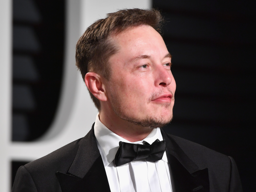

In [94]:
from fastdownload import download_url
dest = 'elon.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'jackie chan'


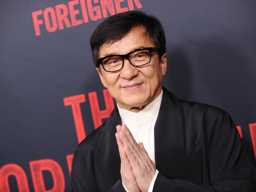

In [95]:
download_url(search_images('jackie chan', max_images=1)[0], 'jackie.jpg', show_progress=False)
Image.open('jackie.jpg').to_thumb(256,256)

In [96]:
searches = 'jackie chan','elon musk'
path = Path('elon_or_jackie')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} face'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun face'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade face'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'jackie chan face'
Searching for 'jackie chan sun face'
Searching for 'jackie chan shade face'
Searching for 'elon musk face'
Searching for 'elon musk sun face'
Searching for 'elon musk shade face'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [97]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

19

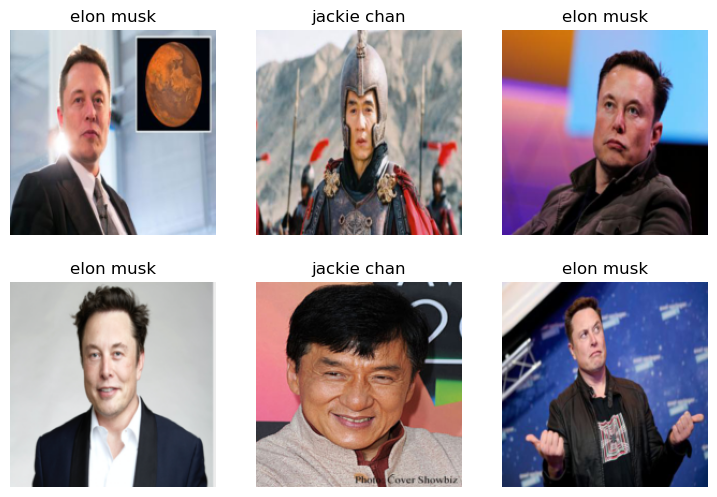

In [98]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [99]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.530785,3.171494,0.592593,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.673844,1.649391,0.518519,00:18
1,0.381102,0.656830,0.185185,00:18
2,0.292216,0.327017,0.111111,00:18
3,0.221347,0.257451,0.111111,00:18
4,0.172794,0.203712,0.111111,00:18


In [100]:
is_elon,_,probs = learn.predict(PILImage.create('elon.jpg'))
print(f"This is : {is_elon}.")
print(f"Probability it's Elon is: {probs[0]:.4f}")

This is : elon musk.
Probability it's Elon is: 0.9973
